# Signs of Smoking: Classifying Smokers Using Biological Health Indicators

Group 005-36: Elena Greenall, Noah Hynds, Dillon Li

### **Introduction**
Despite the knowledge that smoking harms nearly every organ in the human body (NIH, 2022), the prevalence of Canadian cigarette smoking in 2020 was 10% (Health Canada, n.d.). Daily smoking is associated with increased AST and ALT levels, which are enzymes released in response to liver damage (Jang, 2012). In addition, nicotine increases blood glucose concentration (CDC, 2022), as well as increases triglyceride levels (van der Plas, 2023). As such, the goal of this project is to use these biological indicators to classify patients based on their smoking status.  


The question we aim to answer is:<em> Can we predict if a patient is a smoker, based on AST levels, ALT levels, fasting blood sugar levels and triglyceride levels? <em>

We will use the Body Signal of Smoking dataset from <a href ="https://www.kaggle.com/datasets/kukuroo3/body-signal-of-smoking/data"> Kaggle</a>, by Kukuroo3. The dataset contains biological health data of smokers and nonsmokers. Due to the number of predictor variables contained within this dataset, we have chosen to focus on AST levels, ALT levels, fasting blood sugar levels and triglyceride levels as our research has revealed their relevance to smoking.  

### **Methods**

**Loading, Cleaning and Preprocessing Data**

The first step is to import the necessary libraries needed for the analysis. 

In [12]:
#import the necessary libraries
library(tidyverse)
library(tidymodels)
library(RColorBrewer)

Next, we load the dataset into Jupyter and add column names. The smoking variable is mutated to a factor data type, and because the dataset contains 55962 points, 1000 points are selected (500 smokers and 500 non-smokers). We create a new data frame that has these 1000 data points.

In [2]:
set.seed(2024)

#import and clean data
smoking_df <- read.csv("https://raw.githubusercontent.com/egreenall1/dsci100_group_project/main/smoking.csv")
colnames(smoking_df) <- c("ID", "gender","age", "height_cm", "weight_kg", 
                          "waist_cm", "eyesight_left", "eyesight_right", 
                          "hearing_left", "hearing_right", "systolic", 
                          "relaxation", "fasting_blood_sugar", "cholesterol", 
                          "triglyceride", "HDL", "LDL", "hemoglobin", 
                          "urine_protein", "serum_creatine", "AST", 
                          "ALT", "Gtp", "oral", "dental_carries", "tartar", "smoking")

smoking_df <- mutate(smoking_df, smoking = as_factor(smoking))

#the data must be filtered because of the quantity contained in the original set
smoking_smoker_sample <- smoking_df |> 
    filter(smoking == 1) |> 
    slice(1:500)
smoking_nonsmoker_sample <- smoking_df |> 
    filter(smoking == 0) |> 
    slice(1:500)

#a new dataframe with the subsetted data is created
smoking_df <- rbind(smoking_smoker_sample, smoking_nonsmoker_sample)

We have many predictor variables in our dataset, but we do not want to use all of them. Based on our research, we choose to use AST, ALT, triglyceride and fasting blood sugar levels because these are affected by smoking. 
- Fasting blood sugar: blood sugar after approximately 8-12 hours of not eating
-  Triglyceride: a type of fat found in the body
- AST: an enzyme released by the liver when damaged
- ALT: an enzyme released by the liver when damaged

Since our `smoking_df` contains all the variables in the dataset, we must select only our chosen predictors and create a new data frame. We also keep gender in the data frame.

In [3]:
#select only the predictors we are interested in
smoking_df <- select(smoking_df, gender, AST, ALT, triglyceride, fasting_blood_sugar, smoking)

#use the head function to confirm the data has properly been selected without printing the whole dataframe
head(smoking_df)

,gender,AST,ALT,triglyceride,fasting_blood_sugar,smoking
,<chr>,<int>,<int>,<int>,<int>,<fct>
1,M,21,16,182,89,1
2,M,21,27,68,94,1
3,M,21,27,210,112,1
4,M,37,43,318,79,1
5,M,23,19,119,115,1
6,M,29,35,77,87,1


**Table 1:** Smoking data after cleaning and selecting predictors

Using our tidy data (`smoking_data_scaled`), we divide the data frame into a training and testing set using `inital_split`. The training set will be used to train the classifier. We choose a split of 75:25 to ensure the training set has enough observations to create the model, while also making sure we have enough testing data to estimate the prediction accuracy.

In [10]:
set.seed(2024)
#now that the data is clean, we can split the data into training and test data
smoking_split <- initial_split(smoking_data_scaled, prop = 0.75, strata = smoking)  
    smoking_training_data <- training(smoking_split)
    smoking_testing_data <- testing(smoking_split)

Before moving any further with the analysis, we want to make sure that we can see mean differences in the predictors when looking at smokers and nonsmokers. We use the training data (`smoking_training_data`) to create a summary of our predictors with the `group_by` and `summarize` functions.

In [9]:
#now we create a summary of our predictors to see if there are differencs between smokers and non smokers
smoking_summary <- smoking_training_data |> 
    group_by(smoking) |> 
    summarize(mean(AST), mean(ALT), mean(fasting_blood_sugar), mean(triglyceride))

smoking_summary

smoking,mean(AST),mean(ALT),mean(fasting_blood_sugar),mean(triglyceride)
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
0,23.53867,22.66667,96.58933,111.6053
1,27.52267,28.95200,100.78667,145.8960


**Table 2:** Mean values for each predictor 

Based on this table, we see that there are indeed differences in the means of our predictors between smokers (1) and nonsmokers (0). The means of the predictors of the smokers are all higher than those of the nonsmokers. For instance, the mean AST level in nonsmokers is 23.54 units/L, while in smokers it is 27.52 units/L. The same pattern can be seen for the other predictors, and a particularly large difference is seen for mean triglycerides (111.61 mmol/L for nonsmokers and 145.90 mmol/L for smokers).

We now want visualise our predictors to understand if there is a relationship by using `ggplot`. We use `color` to divide the points into smokers and nonsmokers, and also separate the points by gender using `shape` for improved visualisation. `alpha` is set to 0.7 to improve the visualisation. For the first plot, we compare AST and ALT levels.

Warning message:
“Removed 562 rows containing missing values or values outside the scale range
(`geom_point()`).”


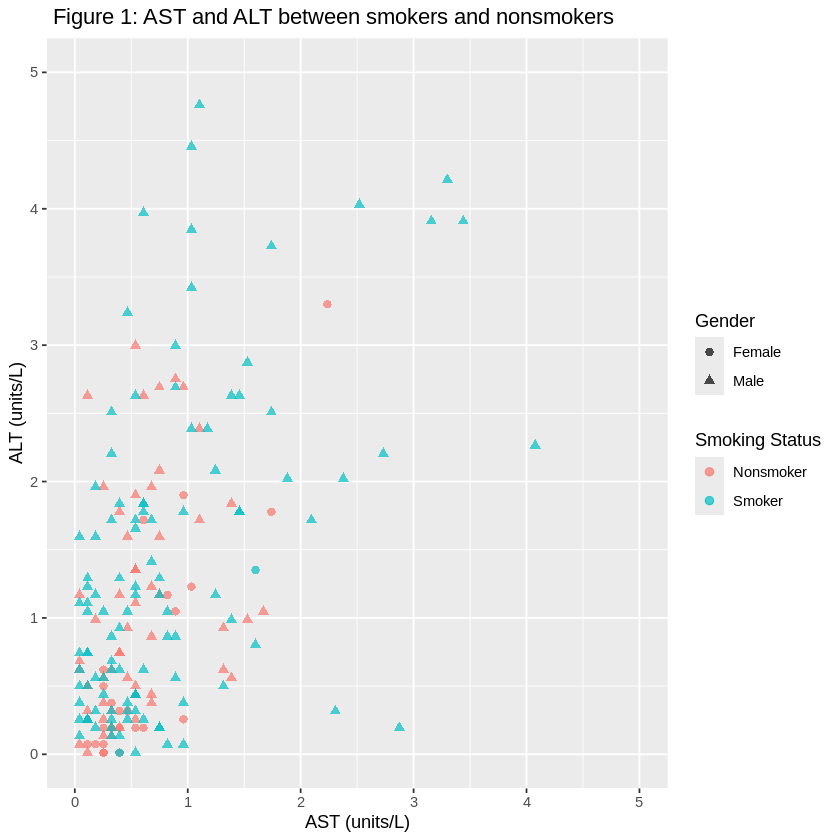

In [8]:
#create a plot of AST vs ALT
smoking_training_plot_AST_ALT <- ggplot(smoking_training_data, aes(x = scaled_AST, y = scaled_ALT)) + 
    geom_point(alpha = 0.7, aes(color = smoking, shape = gender), size = 2) + 
    labs(x = "AST (units/L)", y = "ALT (units/L)", title = " Figure 1: AST and ALT between smokers and nonsmokers", color = "Smoking Status", shape = "Gender") + 
    xlim(0, 5) + 
    ylim(0, 5) +
    scale_colour_discrete(labels = c("Nonsmoker", "Smoker")) +
    scale_shape_discrete(labels = c("Female", "Male"))
smoking_training_plot_AST_ALT

In Figure 1, we see that smokers and nonsmokers generally have similar AST and ALT levels. Although not many, more smokers appear in the upper right hand corner of the plot, suggesting they have larger values for AST and ALT. Similarly, nonsmokers seem to be concentrated in the lower left hand corner of the plot, suggesting they have lower AST and ALT values.

We then repeat this visualisation exploration using triglycerides and fasting blood sugar instead.

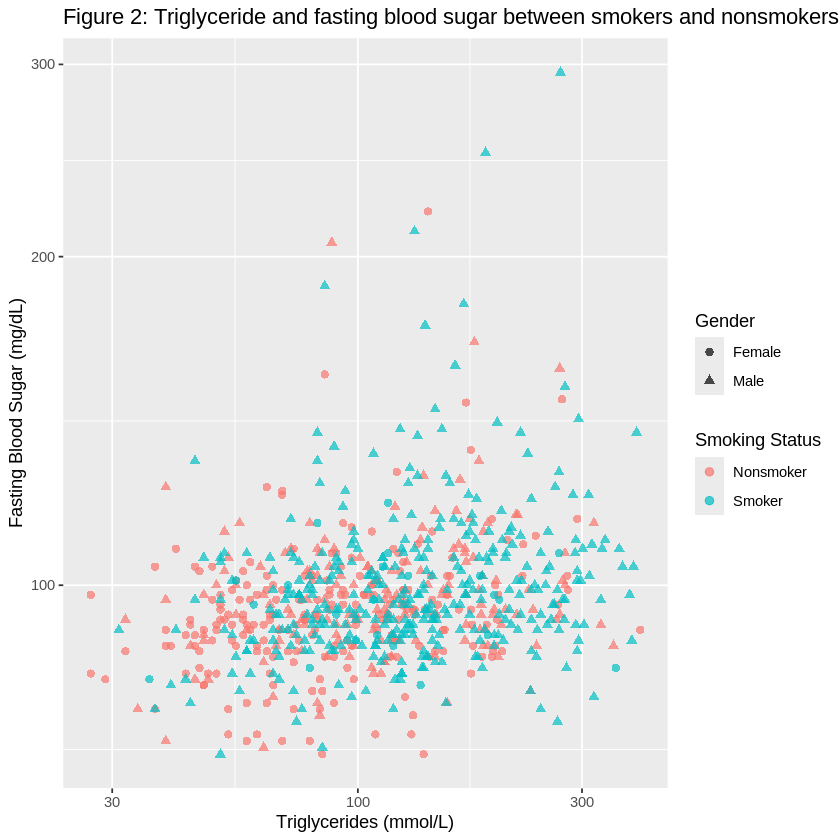

In [130]:
#create a plot of triglycerides vs fasting blood sugar
smoking_training_plot_triglycerides_fasting_blood_sugar <- ggplot(smoking_training_data, aes(x = triglyceride, y = fasting_blood_sugar)) + 
    geom_point(alpha = 0.7, aes(color = smoking, shape = gender), size = 2) + 
    labs(x = "Triglycerides (mmol/L)", y = "Fasting Blood Sugar (mg/dL)", title = "Figure 2: Triglyceride and fasting blood sugar between smokers and nonsmokers", color = "Smoking Status", shape = "Gender") + 
    scale_x_log10() + 
    scale_y_log10() +
    scale_colour_discrete(labels = c("Nonsmoker", "Smoker")) +
    scale_shape_discrete(labels = c("Female", "Male"))

smoking_training_plot_triglycerides_fasting_blood_sugar

In Figure 2, we see that smokers and nonsmokers generally have similar triglyceride and fasting blood sugar levels. More smokers  appear on the right hand side of the plot, suggesting they have slightly larger triglyceride values. This aligns with what we observed in the summary statistics (`smoking_summary`) previously.

Since we know we will be using these variables for K-NN analysis, we scale them to ensure that variables with a larger scale do not have a larger effect than variables with a smaller scale. 

In [11]:
#we scale the variables
smoking_data_scaled <- smoking_df |> 
    mutate(scaled_ALT = scale(ALT, center = TRUE), 
    scaled_AST = scale(AST, center = TRUE),
    scaled_triglyceride = scale(triglyceride, center = TRUE),
    scaled_fasting_blood_sugar = scale(fasting_blood_sugar, center = TRUE))

head(smoking_data_scaled)

,gender,AST,ALT,triglyceride,fasting_blood_sugar,smoking,scaled_ALT,scaled_AST,scaled_triglyceride,scaled_fasting_blood_sugar
,<chr>,<int>,<int>,<int>,<int>,<fct>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>"
1,M,21,16,182,89,1,-0.59632476,-0.3122486,0.7359182,-0.4455933
2,M,21,27,68,94,1,0.07336103,-0.3122486,-0.8566458,-0.2213164
3,M,21,27,210,112,1,0.07336103,-0.3122486,1.1270743,0.5860804
4,M,37,43,318,79,1,1.04744947,0.8206261,2.6358192,-0.8941471
5,M,23,19,119,115,1,-0.41368318,-0.1706393,-0.1441829,0.7206465
6,M,29,35,77,87,1,0.56040525,0.2541888,-0.7309170,-0.5353041


**Table 2:** Smoking data with scaled variables

**K-Nearest Neighbours Model**

Now that we have cleaned and explored our dataset, we can start producing the K-nearest neighbours model. 

First we prepare a recipe using the `recipe` function, and the training data (`smoking_training_data`). We also center the predictors so there is a mean of 0 and standard deviation of 1. We do not have an issue with class imbalance since we have 500 points for smokers and 500 points for nonsmokers. 

In [131]:
set.seed(2024)

#preparing a recipe
knn_recipe <- recipe(smoking ~ scaled_AST + scaled_ALT + scaled_triglyceride + scaled_fasting_blood_sugar, data = smoking_training_data) |>
    step_center(all_predictors())

Next, we prepare a K-NN model specification. In this model, the engine must be set to `kknn` and the mode is set to `classification`. `weight_func` is set to `rectangular`, which means that each neighbouring point has the same weight. Since we want to determine the best K value for this model, we use `tune()` in the `neighbors` function. 

In [132]:
set.seed(2024)

#creating the K-nearest neighbour model
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
    set_engine("kknn") |> 
    set_mode("classification")

Now we tune the model to choose the best K value (the number of neighbours that gives the best accuracy). This is achieved via 5 fold cross validation (`vfold_cv`). We choose 5 instead of 10 folds due to the size of the data.

In [133]:
set.seed(2024)

#using vfold_cv to perform 5-fold cross validation on the training data 
vfold <- vfold_cv(smoking_training_data, v = 5, strata = smoking)

Now, we create a new data frame (`values`) that contains K values from 150 to 200 with the `seq` function. That data frame is then passed as an argument in `tune_grid`. We use `tune_grid` to fit the model for each K value in a range of parameter values.

We then determine the best number of neighbors by creating a data frame of accuracy vs K (`knn_best`), organised in descending order using `desc()` so we see the highest accuracy first. 

In [134]:
set.seed(2024)

values <- tibble(neighbors = seq(from = 150, to = 200, by = 5))

#creating a workflow to find the best K value 
knn_best <- workflow() |> 
    add_recipe(knn_recipe) |> 
    add_model(knn_spec) |> 
    tune_grid(resamples = vfold, grid = values) |>
#determining accuracy 
    collect_metrics() |> 
    filter(.metric == "accuracy") |>
    select(neighbors, mean) |>
    arrange(desc(mean))

head(knn_best)

neighbors,mean
<dbl>,<dbl>
155,0.6000000
195,0.5973333
150,0.5960000
160,0.5946667
200,0.5946667
165,0.5933333


**Table 4:** Accuracy of different K values

We can also determine the best number of neighbors by plotting the K values against the accuracy.

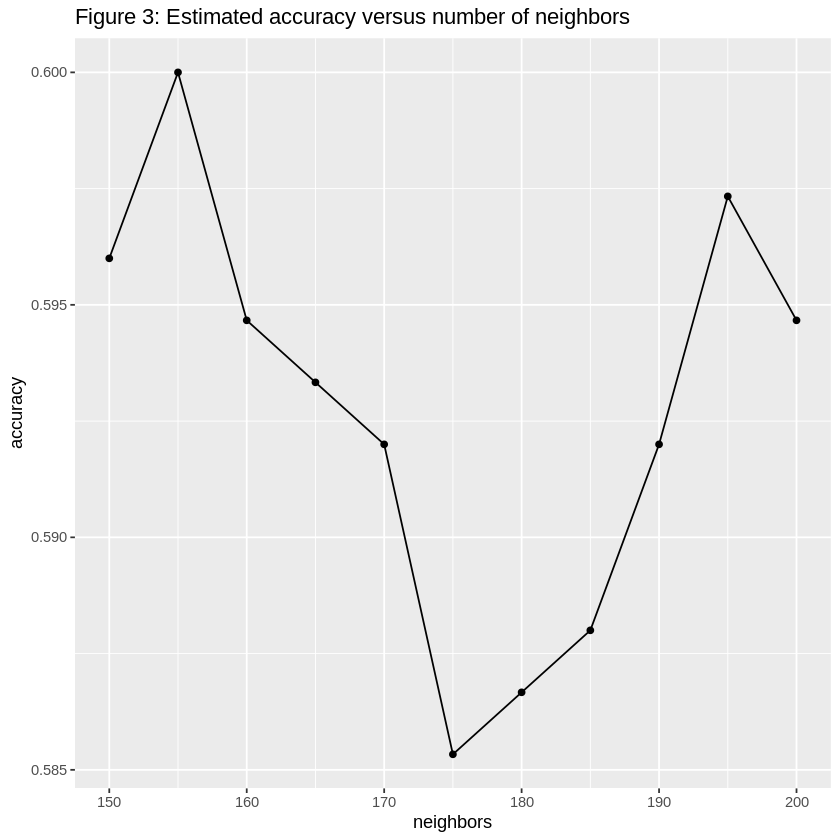

In [135]:
set.seed(2024)

#plotting K versus accuracy 
cross_val_plot <- knn_best |> 
    ggplot(aes(x = neighbors, y = mean)) + 
    geom_point() + 
    geom_line() + 
    labs(x = "neighbors", y = "accuracy", title = "Figure 3: Estimated accuracy versus number of neighbors")
    
cross_val_plot  

Based on Figure 3, we can see that K = 155 has the highest cross-validation accuracy, at 60.0%. As such, we use 155 neighbours for our model. 

Since we now have the most accurate K value, the test data can be used to evaluate the accuracy of the model's predictions. First, the model is retrained on the training data set using the selected K value. 

In [136]:
set.seed(2024)

#creating a new model with our best K value
best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 155) |> 
    set_engine("kknn") |> 
    set_mode("classification")

#create a workflow our new K value
best_fit <- workflow() |> 
    add_recipe(knn_recipe) |> 
    add_model(best_spec) |> 
    fit(data = smoking_training_data) 
best_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(155,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.408
Best kernel: rectangular
Best k: 155

Now that the model is retrained, we used the `predict` and `metrics` functions to determine the accuracy of the model on the test data. Those predictions are then passed into `precision` and `recall` to determine the estimated precision and recall.

In [137]:
set.seed(2024)

#using predict and metrics functions
smoking_predictions <- predict(best_fit, smoking_testing_data) |> 
    bind_cols(smoking_testing_data)

smoking_predictions |> 
    metrics(truth = smoking, estimate = .pred_class) |>
    filter(.metric == "accuracy")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.648


**Table 5:** Accuracy of the model based on testing data

In [138]:
smoking_predictions |>
    precision(truth = smoking, estimate = .pred_class, event_level = "first")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.637037


**Table 6:** Precision of the model based on testing data

In [139]:
smoking_predictions |>
    recall(truth = smoking, estimate = .pred_class, event_level = "first")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.688


**Table 7:** Recall of the model based on testing data

The predictions are finally passed into `conf_mat` to produce a confusion matrix.

In [140]:
#making a confusion matrix
smoking_conf_mat <- smoking_predictions |> 
    conf_mat(truth = smoking, estimate = .pred_class)
smoking_conf_mat

          Truth
Prediction  0  1
         0 86 49
         1 39 76

**Table 8:** Confusion matrix based on testing data

Finally we visualise the results of our analysis using `ggplot`.

`summarise()` has grouped output by '.pred_class'. You can override using the
`.groups` argument.


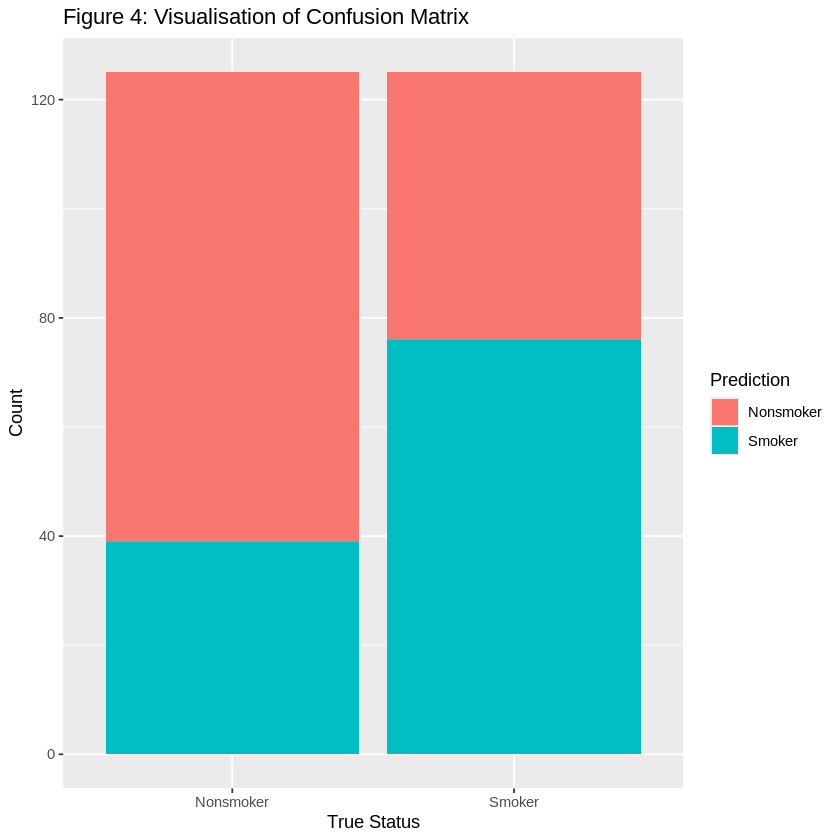

In [141]:
conf_mat_table <- smoking_predictions|>
    select(.pred_class, smoking)|>
    group_by(.pred_class, smoking)|>
    summarize(count = n()) 

new_conf_mat_table <- conf_mat_table |>
    mutate(.pred_class = fct_recode(.pred_class, "Nonsmoker" = "0", "Smoker" = "1")) |>
    mutate(smoking = fct_recode(smoking, "Nonsmoker" = "0", "Smoker" = "1")) 

conf_plot <- new_conf_mat_table|>
    ggplot(aes(x = smoking, y = count, fill = .pred_class)) +
    geom_bar(stat = "identity") +
    labs(x = "True Status", y = "Count", fill = "Prediction") +
    ggtitle("Figure 4: Visualisation of Confusion Matrix") +
    scale_colour_discrete(labels = c("Nonsmoker", "Smoker")) 
conf_plot

### **Discussion**

Our model was developed to answer the question: *Can we predict if a patient is a smoker, based on AST levels, ALT levels, fasting blood sugar levels and triglyceride levels?* In our exploratory data analysis, we found that there were differences in the means of AST level, ALT level, fasting blood sugar level and triglyceride levels between smokers and nonsmokers. As such, we used these predictors to build our classification model and expected to find that these predictors would allow our model to accurately predict an individual's smoking status. 

The model predicted the class in the testing data with an accuracy of 64.8%. The model tended more towards falsely diagnosing smokers as nonsmokers (49 observations) compared to diagnosing nonsmokers as smokers (39 observations). Precision was 63.7%, which indicates that out of every participant predicted as a nonsmoker, only 63.7% were actually nonsmokers. Recall was 68.8%, indicating that out of all the participants who actually are nonsmokers, only 68.8% were predicted correctly. In a healthcare setting, this could potentially have troubling consequences. If smokers are improperly identified as nonsmokers, this may prevent them from receiving needed treatment, but also put them at risk if they receive a treatment that is not approved for smokers. Conversely, if nonsmokers are falsely identified as smokers, they may receive medications that have increased concentrations to account for tissue damage in smoker bodies, which could be harmful. Increasing the accuracy of our model would help to minimize the impacts of misdiagnosis. 

In the context of this model, a higher accuracy would be beneficial, but a slightly lower accuracy could be acceptable. In other words, an incorrect diagnosis of "smoker" or "nonsmoker" is not inherently life threating in the same way that an incorrect cancer classification might be. However, there are still a few considerations that may have impacted accuracy of the model. First, the correlation between the variables was not very strong. Many of the data points for AST/ALT and fasting blood sugar/triglycerides were packed tightly together, meaning they may not have differed as significantly between smokers and nonsmokers than originally thought. For instance, when looking at a smoker point, the points nearby consisted of a mix of points that included smokers and nonsmokers rather than just smokers. This mix of points would have affected the majority vote, thus affecting the classifier's accuracy. Second, choosing K = 155 may have resulted in underfitting. This means the model is not influenced enough by the training data, which leads to a model that cannot generalize to new data. 

To improve the accuracy of the model, one option would be to try using 10-fold cross validation. A higher number of folds would improve the accuracy of the estimate by reducing standard error, which may be worth it for our model despite increasing the time to run the analysis. Another option would be to adjust the 75:25 ratio for the training:testing data. In particular, this would mean increasing the amount of testing data in an attempt to get a more accurate evaluation of the model's performance. Finally, using a different statistical model like the K-means algorithm to cluster the data into smokers and nonsmokers could improve the accuracy.

The findings of this analysis can contribute to increased awareness of the biological indicators that might be impacted by smoking. When considering the future of this model, one question to consider is if other biological indicators included in the original dataset might be better for distinguishing smokers and nonsmokers, thus improving the model's accuracy. Another future question to better understand how this model works would be to look at how at how it classifies former smokers. This could indicate if this model would be useful clinically. 

### **References**

CDC (2022). Smoking and Diabetes. https://www.cdc.gov/diabetes/library/features/smoking-and-diabetes.html#:~:text=How%20Smoking%20Can%20Lead%20to,cells%20stop%20responding%20to%20insulin

Health Canada (2022). Canadian Tobacco and Nicotine Survey (CTNS): summary of results for 2020. https://www.canada.ca/en/health-canada/services/canadian-tobacco-nicotine-survey/2020-summary.html

Jang, E.S., Jeong, SH., Hwang, S.H. et al. Effects of coffee, smoking, and alcohol on liver function tests: a comprehensive cross-sectional study. BMC Gastroenterol 12, 145 (2012). https://doi.org/10.1186/1471-230X-12-145

Kukuroo3. (n.d.). Body signal of smoking. Retrieved from https://www.kaggle.com/datasets/kukuroo3/body-signal-of-smoking/data

NIH (2022). How Smoking Affects the Heart and Blood Vessels. https://www.nhlbi.nih.gov/health/heart/smoking

van der Plas, A., Antunes, M., Pouly, S., de La Bourdonnaye, G., Hankins, M., & Heremans, A. (2023). Meta-analysis of the effects of smoking and smoking cessation on triglyceride levels. Toxicology Reports, 10, 367-375.